<a href="https://colab.research.google.com/github/YianKim/2022_PythonStudy_face_emotion_recognition/blob/main/GAN_fer2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import argparse

import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import BatchNormalization
from keras.datasets import mnist
from keras import optimizers
from keras import initializers
from keras import backend as K
import PIL
import pickle
import random

from keras.regularizers import l2

K.set_image_data_format('channels_first')

In [2]:
def load_data(dataset_path):
  
  #classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprsie', 'Neutral']

  data = []
  test_data = []
  test_labels = []
  labels =[]

  with open(dataset_path, 'r') as file:
      for line_no, line in enumerate(file.readlines()):
          if 0 < line_no <= 35887:
            curr_class, line, set_type = line.split(',')
            image_data = np.asarray([int(x) for x in line.split()]).reshape(48, 48)
            image_data =image_data.astype(np.uint8)/255.0

            if (set_type.strip() == 'PrivateTest'):
              
              test_data.append(image_data)
              test_labels.append(curr_class)
            else:
              data.append(image_data)
              labels.append(curr_class)
      
      test_data = np.expand_dims(test_data, -1)
      test_labels = to_categorical(test_labels, num_classes = 7)
      data = np.expand_dims(data, -1)   
      labels = to_categorical(labels, num_classes = 7)
    
      return np.array(data), np.array(labels), np.array(test_data), np.array(test_labels)

dataset_path = "/content/drive/MyDrive/파이썬스터디 프로젝트/fer2013.csv/fer2013.csv"
train_data, train_labels, test_data, test_labels = load_data(dataset_path)
#train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = test_size,random_state = seed)

#평가용
test_labels2 = np.argmax(test_labels, axis=1)

# print("Number of images in Training set:", len(train_data))
# print("Number of images in Test set:", len(test_data))

with open('/content/drive/MyDrive/파이썬스터디 프로젝트/aug_array1.pkl', 'rb') as f:
	aug_array1 = pickle.load(f)
 
train_data_aug = np.concatenate((train_data, aug_array1), axis=0).reshape([-1,48,48])
train_labels_aug = np.concatenate((train_labels, train_labels), axis=0)

In [3]:
trl = []
for i in train_labels_aug:
  trl.append(i.tolist().index(1))
tel = []
for i in test_labels:
  tel.append(i.tolist().index(1))

In [26]:
class Data:
    """
    Define dataset for training GAN
    """
    def __init__(self, batch_size, z_input_dim):
        # load mnist dataset
        # 이미지는 보통 -1~1 사이의 값으로 normalization : generator의 outputlayer를 tanh로
        (X_train, y_train), (X_test, y_test) = (train_data_aug, trl), (test_data, tel)
        self.x_data = ((X_train - 0.5) * 2)
        self.x_data = self.x_data.reshape((self.x_data.shape[0], 1) + self.x_data.shape[1:])
        self.batch_size = batch_size
        self.z_input_dim = z_input_dim

    def get_real_sample(self):
        """
        get real sample mnist images

        :return: batch_size number of mnist image data
        """
        return self.x_data[np.random.randint(0, self.x_data.shape[0], size=self.batch_size)]

    def get_z_sample(self, sample_size):
        """
        get z sample data

        :return: random z data (batch_size, z_input_dim) size
        """
        return np.random.uniform(-1.0, 1.0, (sample_size, self.z_input_dim))

In [61]:
class GAN:
    def __init__(self, learning_rate, z_input_dim):
        """
        init params

        :param learning_rate: learning rate of optimizer
        :param z_input_dim: input dim of z
        """
        self.learning_rate = learning_rate
        self.z_input_dim = z_input_dim
        self.D = self.discriminator()
        self.G = self.generator()
        self.GD = self.combined()

    def discriminator(self):
        """
        define discriminator
        """
        D = Sequential()
        D.add(Conv2D(256, (3, 3), input_shape=(1, 48, 48), kernel_regularizer=l2(0.01),
                     kernel_initializer=initializers.RandomNormal(stddev=0.02)))
        D.add(LeakyReLU(0.2))
        D.add(Conv2D(512, (3, 3), padding='same'))
        D.add(LeakyReLU(0.2))
        D.add(BatchNormalization())
        D.add(MaxPooling2D(pool_size=(2,2)))
        D.add(Dropout(0.4))

        D.add(Conv2D(384, (3, 3), padding='same'))
        D.add(LeakyReLU(0.2))
        D.add(BatchNormalization())
        D.add(MaxPooling2D(pool_size=(2,2)))
        D.add(Dropout(0.4))

        D.add(Conv2D(192, (3, 3), padding='same'))
        D.add(LeakyReLU(0.2))
        D.add(BatchNormalization())
        D.add(MaxPooling2D(pool_size=(2,2)))
        D.add(Dropout(0.4))

        D.add(Conv2D(384, (3, 3), padding='same'))
        D.add(LeakyReLU(0.2))
        D.add(BatchNormalization())
        D.add(MaxPooling2D(pool_size=(2,2)))
        D.add(Dropout(0.4))

        D.add(Flatten())
        D.add(Dense(256))
        D.add(LeakyReLU(0.2))
        D.add(BatchNormalization())
        D.add(Dropout(0.3))
        D.add(Dense(1, activation='sigmoid'))
        # output : 진짜 / 가짜 : 1 (sigmoid를 통해 0.5 기준으로 classification)
        adam = keras.optimizers.Adam(lr=self.learning_rate/15, beta_1=0.5)
        D.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        return D

    def generator(self):
        """
        define generator
        """

        G = Sequential()
        #512는 출력뉴런의 수, input_dim은 입력뉴런의 수
        G.add(Dense(512, input_dim=self.z_input_dim))
        G.add(LeakyReLU(0.2))
        G.add(Dense(256 * 12 * 12))
        G.add(LeakyReLU(0.2))
        G.add(BatchNormalization())
        # reshape하면 output shape 형태 (batch_size,) + target_shape
        G.add(Reshape((256, 12, 12), input_shape=(256 * 12 * 12,)))
        G.add(UpSampling2D(size=(2, 2)))
        G.add(Conv2D(256, (5, 5), padding='same', activation='tanh'))
        G.add(UpSampling2D(size=(2, 2)))
        G.add(Conv2D(1, (5, 5), padding='same', activation='tanh'))

        adam = keras.optimizers.Adam(lr=self.learning_rate, beta_1=0.5)
        G.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        return G

    def combined(self):
        """
        defien combined gan model
        """
        G, D = self.G, self.D
        D.trainable = False
        GD = Sequential()
        GD.add(G)
        GD.add(D)

        adam = keras.optimizers.Adam(lr=self.learning_rate, beta_1=0.5)
        GD.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        D.trainable = True
        return GD

In [59]:
# GAN의 두 개의 네트워크를 트레이닝 하다 보면 다음과 같은 문제가 생길 수 있다.
# discriminator가 너무 뛰어나면 0이나 1에 매우 가까운 gradient값을 반환하게 되어, generator가 gradient값을 제대로 반영하기 어렵게 된다.
# generator가 너무 뛰어나면 discriminator가 진짜 데이터를 가짜 데이터로 판단할 확률이 높아진다. 이러한 문제는 두 신경망의 학습률(learning rates)을 각각 설정하여 완화할 수 있다.
# 두 개의 신경망은 항상 비슷한 “학습 수준”을 유지해야 한다.

class Model:
    def __init__(self, batch_size, epochs, learning_rate, z_input_dim, n_iter_D, n_iter_G):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.z_input_dim = z_input_dim
        self.data = Data(self.batch_size, self.z_input_dim)

        # the reason why D, G differ in iter : Generator needs more training than Discriminator
        self.n_iter_D = n_iter_D
        self.n_iter_G = n_iter_G
        self.gan = GAN(self.learning_rate, self.z_input_dim)

        # print status
        batch_count = self.data.x_data.shape[0] / self.batch_size
        print('Epochs:', self.epochs)
        print('Batch size:', self.batch_size)
        print('Batches per epoch:', batch_count)
        print('Learning rate:', self.learning_rate)
        print('Image data format:', K.image_data_format())

    def fit(self):
        self.d_loss = []
        self.g_loss = []
        for epoch in range(self.epochs):

            # train discriminator by real data
            dloss = 0
            for iter in range(self.n_iter_D):
                dloss = self.train_D()

            # train GD by generated fake data
            gloss = 0
            for iter in range(self.n_iter_G):
                gloss = self.train_G()

            # save loss data
            self.d_loss.append(dloss)
            self.g_loss.append(gloss)

            # plot and save model each 20n epoch
            if epoch % 20 == 0:
                self.plot_generate_images(epoch, self.gan.G, examples=8)
                print('Epoch:', str(epoch))
                print('Discriminator loss:', str(dloss))
                print('Generator loss:', str(gloss))
        
        # show loss after train
        self.plot_loss_graph(self.g_loss, self.d_loss)

    def train_D(self):
        """
        train Discriminator
        """

        # Real data
        real = self.data.get_real_sample()

        # Generated data
        z = self.data.get_z_sample(self.batch_size)
        generated_images = self.gan.G.predict(z)

        # labeling and concat generated, real images
        x = np.concatenate((real, generated_images), axis=0)
        y = [0.9] * self.batch_size + [0] * self.batch_size
        y = np.array(y)

        # train discriminator
        self.gan.D.trainable = True
        loss = self.gan.D.train_on_batch(x, y)
        return loss

    def train_G(self):
        """
        train Generator
        """

        # Generated data
        z = self.data.get_z_sample(self.batch_size)

        # labeling
        y = [1] * self.batch_size
        y = np.array(y)

        # train generator
        self.gan.D.trainable = False
        loss = self.gan.GD.train_on_batch(z, y)
        return loss

    def plot_loss_graph(self, g_loss, d_loss):
        """
        Save training loss graph
        """

        # show loss graph
        plt.figure(figsize=(10, 8))
        plt.plot(d_loss, label='Discriminator loss')
        plt.plot(g_loss, label='Generator loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plot_generate_images(self, epoch, generator, examples=8):
        """
        Save generated mnist images
        """
        # plt info
        dim = (10, 10)
        figsize = (10, 10)

        # generate images
        z = self.data.get_z_sample(examples)
        generated_images = generator.predict(z)

        # show images
        plt.figure(figsize=figsize)
        for i in range(generated_images.shape[0]):
            plt.subplot(dim[0], dim[1], i + 1)
            plt.imshow(generated_images[i].reshape((48,48)), interpolation='nearest', cmap='gray_r')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epochs: 3000
Batch size: 64
Batches per epoch: 1009.3125
Learning rate: 0.001
Image data format: channels_first


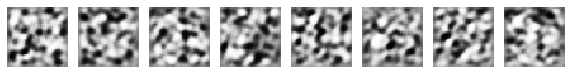

Epoch: 0
Discriminator loss: [0.6727346777915955, 0.484375]
Generator loss: [0.4621303975582123, 1.0]


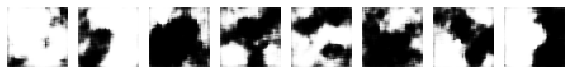

Epoch: 20
Discriminator loss: [0.32149457931518555, 0.484375]
Generator loss: [0.4003787934780121, 1.0]


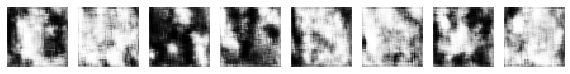

Epoch: 40
Discriminator loss: [0.46625131368637085, 0.421875]
Generator loss: [0.10932787507772446, 1.0]


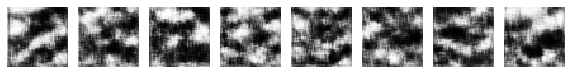

Epoch: 60
Discriminator loss: [0.38437220454216003, 0.46875]
Generator loss: [0.0811087116599083, 1.0]


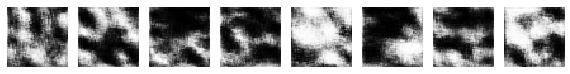

Epoch: 80
Discriminator loss: [0.7490810751914978, 0.3671875]
Generator loss: [0.06071215867996216, 1.0]


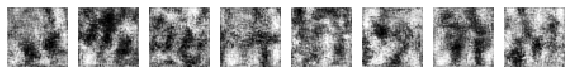

Epoch: 100
Discriminator loss: [0.6838557720184326, 0.359375]
Generator loss: [0.05591040477156639, 1.0]


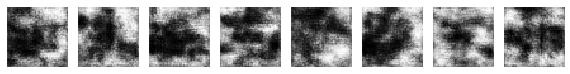

Epoch: 120
Discriminator loss: [0.5937287211418152, 0.4296875]
Generator loss: [0.06751099973917007, 1.0]


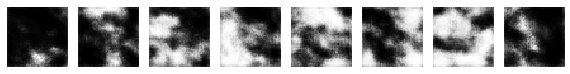

Epoch: 140
Discriminator loss: [0.6576636433601379, 0.390625]
Generator loss: [0.08601071685552597, 1.0]


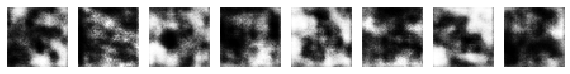

Epoch: 160
Discriminator loss: [0.9220719933509827, 0.3515625]
Generator loss: [0.10118072479963303, 1.0]


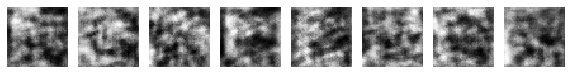

Epoch: 180
Discriminator loss: [0.573764979839325, 0.4140625]
Generator loss: [0.06734602153301239, 1.0]


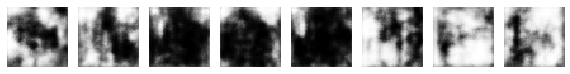

Epoch: 200
Discriminator loss: [0.8806656002998352, 0.34375]
Generator loss: [0.11774584650993347, 1.0]


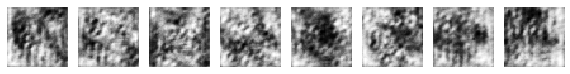

Epoch: 220
Discriminator loss: [0.5461553931236267, 0.421875]
Generator loss: [0.08425750583410263, 1.0]


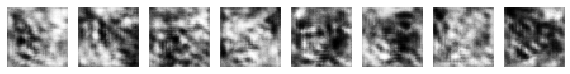

Epoch: 240
Discriminator loss: [0.47869056463241577, 0.4453125]
Generator loss: [0.11925073713064194, 1.0]


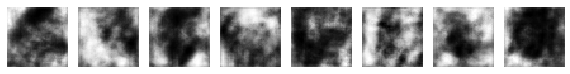

Epoch: 260
Discriminator loss: [0.4665592610836029, 0.4453125]
Generator loss: [0.09587544947862625, 1.0]


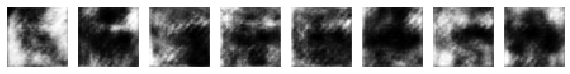

Epoch: 280
Discriminator loss: [0.6874728202819824, 0.40625]
Generator loss: [0.19214436411857605, 0.984375]


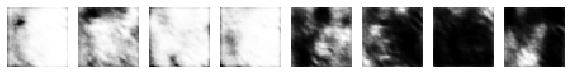

Epoch: 300
Discriminator loss: [0.4988004267215729, 0.4453125]
Generator loss: [0.15323632955551147, 1.0]


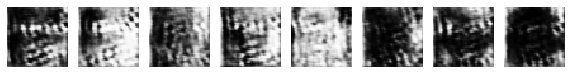

Epoch: 320
Discriminator loss: [0.4515463709831238, 0.4375]
Generator loss: [0.13877691328525543, 1.0]


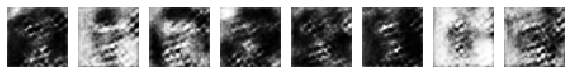

Epoch: 340
Discriminator loss: [0.4174235761165619, 0.46875]
Generator loss: [0.17784592509269714, 0.984375]


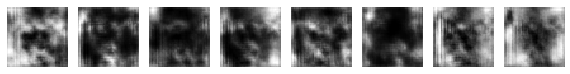

Epoch: 360
Discriminator loss: [0.842236340045929, 0.34375]
Generator loss: [0.18340426683425903, 1.0]


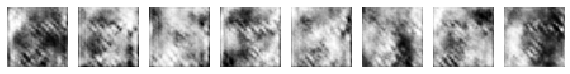

Epoch: 380
Discriminator loss: [0.552109956741333, 0.421875]
Generator loss: [0.3334745466709137, 0.90625]


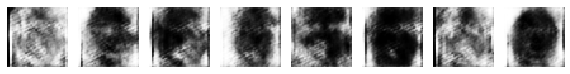

Epoch: 400
Discriminator loss: [0.5376144647598267, 0.4765625]
Generator loss: [0.24296541512012482, 0.984375]


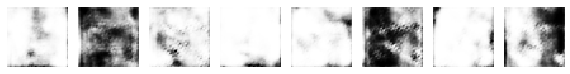

Epoch: 420
Discriminator loss: [0.6021178960800171, 0.4140625]
Generator loss: [0.476152241230011, 0.78125]


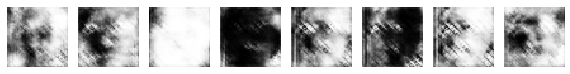

Epoch: 440
Discriminator loss: [0.3688488006591797, 0.4921875]
Generator loss: [0.5902668237686157, 0.71875]


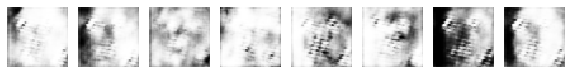

Epoch: 460
Discriminator loss: [0.4955979287624359, 0.421875]
Generator loss: [0.5711178183555603, 0.703125]


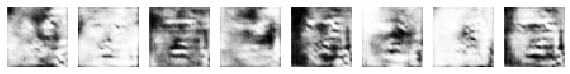

Epoch: 480
Discriminator loss: [0.4830590486526489, 0.4140625]
Generator loss: [1.080789566040039, 0.40625]


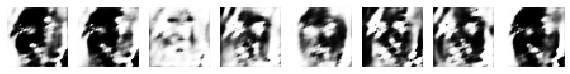

Epoch: 500
Discriminator loss: [0.7086169123649597, 0.390625]
Generator loss: [0.6362938284873962, 0.65625]


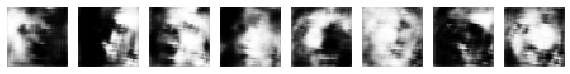

Epoch: 520
Discriminator loss: [0.28115686774253845, 0.4765625]
Generator loss: [1.4520002603530884, 0.0625]


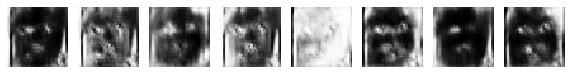

Epoch: 540
Discriminator loss: [0.49556267261505127, 0.453125]
Generator loss: [0.5362921357154846, 0.8125]


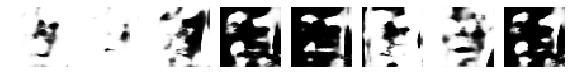

Epoch: 560
Discriminator loss: [0.4961402416229248, 0.4609375]
Generator loss: [1.3221174478530884, 0.203125]


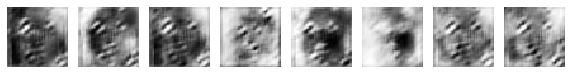

Epoch: 580
Discriminator loss: [0.3091525733470917, 0.484375]
Generator loss: [0.7755503058433533, 0.546875]


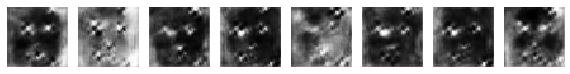

Epoch: 600
Discriminator loss: [0.27178341150283813, 0.4921875]
Generator loss: [0.413728266954422, 0.84375]


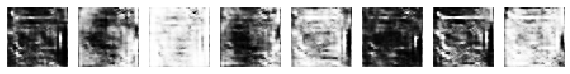

Epoch: 620
Discriminator loss: [0.3199290633201599, 0.4765625]
Generator loss: [2.8999831676483154, 0.015625]


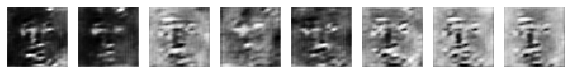

Epoch: 640
Discriminator loss: [0.37499549984931946, 0.484375]
Generator loss: [0.6876402497291565, 0.59375]


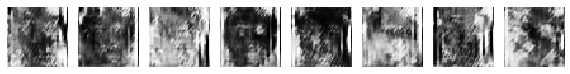

Epoch: 660
Discriminator loss: [0.5253077745437622, 0.4765625]
Generator loss: [2.448636770248413, 0.015625]


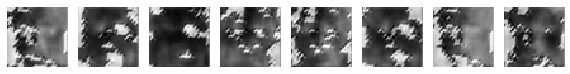

Epoch: 680
Discriminator loss: [0.6786459684371948, 0.4140625]
Generator loss: [0.28736424446105957, 0.953125]


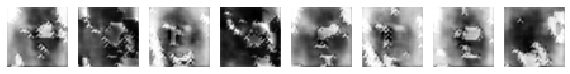

Epoch: 700
Discriminator loss: [0.6761061549186707, 0.375]
Generator loss: [0.4779330790042877, 0.859375]


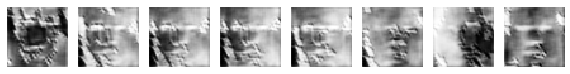

Epoch: 720
Discriminator loss: [0.8295979499816895, 0.3046875]
Generator loss: [1.201995611190796, 0.3125]


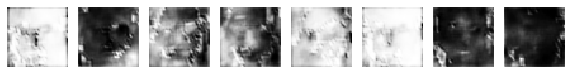

Epoch: 740
Discriminator loss: [0.5643205642700195, 0.4375]
Generator loss: [2.8140668869018555, 0.15625]


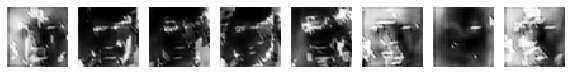

Epoch: 760
Discriminator loss: [0.5304858684539795, 0.453125]
Generator loss: [1.678796648979187, 0.125]


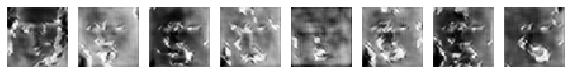

Epoch: 780
Discriminator loss: [0.7101019024848938, 0.3828125]
Generator loss: [0.7129325866699219, 0.546875]


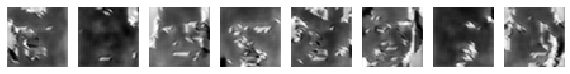

Epoch: 800
Discriminator loss: [0.5257854461669922, 0.4375]
Generator loss: [0.4781910479068756, 0.828125]


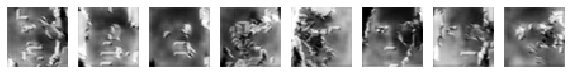

Epoch: 820
Discriminator loss: [0.5355692505836487, 0.3984375]
Generator loss: [0.6877924203872681, 0.53125]


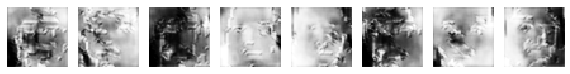

Epoch: 840
Discriminator loss: [0.7988898754119873, 0.375]
Generator loss: [0.9384430646896362, 0.4375]


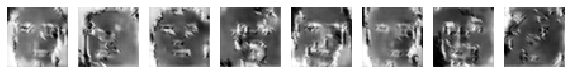

Epoch: 860
Discriminator loss: [0.5855373740196228, 0.4296875]
Generator loss: [0.2708035409450531, 0.9375]


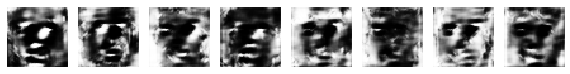

Epoch: 880
Discriminator loss: [0.4473693072795868, 0.46875]
Generator loss: [0.7949676513671875, 0.5625]


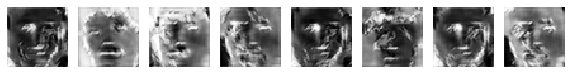

Epoch: 900
Discriminator loss: [0.5711790323257446, 0.4140625]
Generator loss: [1.1036224365234375, 0.390625]


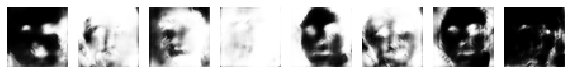

Epoch: 920
Discriminator loss: [0.5903633832931519, 0.4375]
Generator loss: [1.6451942920684814, 0.28125]


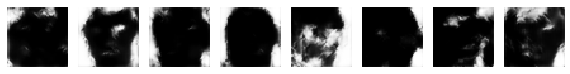

Epoch: 940
Discriminator loss: [0.5496664643287659, 0.4375]
Generator loss: [0.7939636707305908, 0.609375]


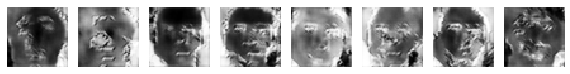

Epoch: 960
Discriminator loss: [0.6037263870239258, 0.421875]
Generator loss: [0.695722222328186, 0.671875]


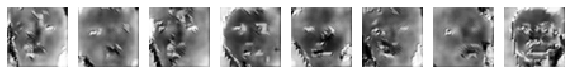

Epoch: 980
Discriminator loss: [0.5603424310684204, 0.421875]
Generator loss: [0.18960362672805786, 0.953125]


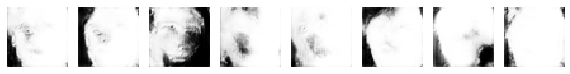

Epoch: 1000
Discriminator loss: [0.6257595419883728, 0.421875]
Generator loss: [2.0725371837615967, 0.171875]


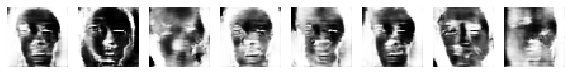

Epoch: 1020
Discriminator loss: [0.3648529052734375, 0.5]
Generator loss: [1.8075227737426758, 0.109375]


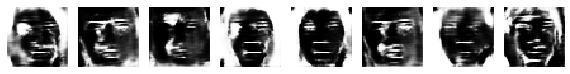

Epoch: 1040
Discriminator loss: [0.2882813513278961, 0.4921875]
Generator loss: [2.038168430328369, 0.125]


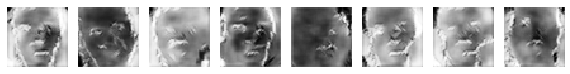

Epoch: 1060
Discriminator loss: [0.5327252149581909, 0.4140625]
Generator loss: [0.3037581741809845, 0.890625]


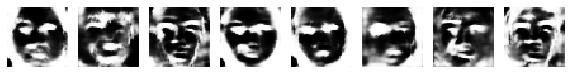

Epoch: 1080
Discriminator loss: [0.37315839529037476, 0.5]
Generator loss: [1.7200723886489868, 0.140625]


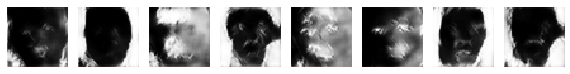

Epoch: 1100
Discriminator loss: [0.8761070966720581, 0.328125]
Generator loss: [1.0458340644836426, 0.40625]


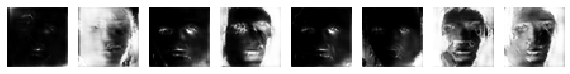

Epoch: 1120
Discriminator loss: [0.3526083827018738, 0.46875]
Generator loss: [2.884172201156616, 0.03125]


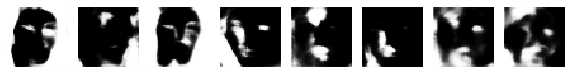

Epoch: 1140
Discriminator loss: [0.3005940318107605, 0.4921875]
Generator loss: [1.0354686975479126, 0.46875]


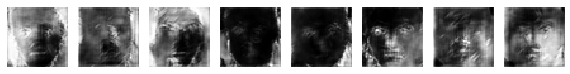

Epoch: 1160
Discriminator loss: [0.6381829380989075, 0.4296875]
Generator loss: [2.2488021850585938, 0.03125]


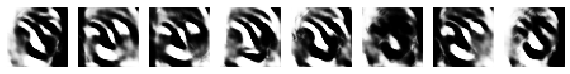

Epoch: 1180
Discriminator loss: [0.258718878030777, 0.5]
Generator loss: [2.1087331771850586, 0.140625]


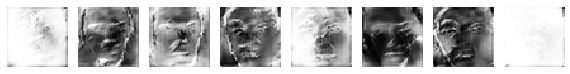

Epoch: 1200
Discriminator loss: [0.2825831174850464, 0.5]
Generator loss: [2.5894033908843994, 0.09375]


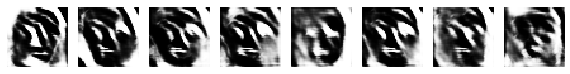

Epoch: 1220
Discriminator loss: [0.243841290473938, 0.5]
Generator loss: [2.909976005554199, 0.046875]


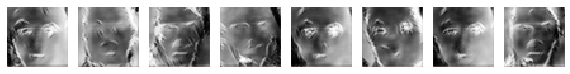

Epoch: 1240
Discriminator loss: [0.4069347679615021, 0.4765625]
Generator loss: [0.18230755627155304, 0.984375]


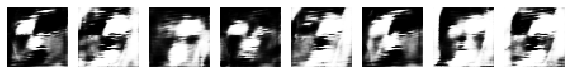

Epoch: 1260
Discriminator loss: [0.24854694306850433, 0.5]
Generator loss: [2.6790339946746826, 0.09375]


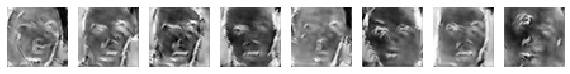

Epoch: 1280
Discriminator loss: [0.4093397855758667, 0.4921875]
Generator loss: [0.1611108034849167, 0.984375]


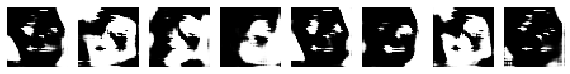

Epoch: 1300
Discriminator loss: [0.2501865327358246, 0.5]
Generator loss: [4.4569621086120605, 0.015625]


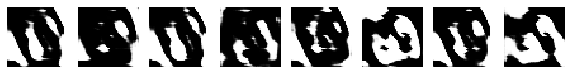

Epoch: 1320
Discriminator loss: [0.2277064323425293, 0.5]
Generator loss: [5.907466888427734, 0.0]


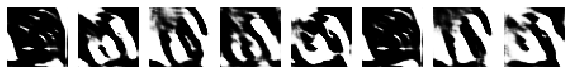

Epoch: 1340
Discriminator loss: [0.23587201535701752, 0.5]
Generator loss: [5.5788984298706055, 0.0]


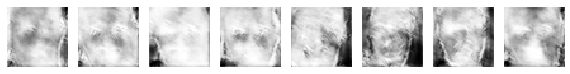

Epoch: 1360
Discriminator loss: [0.27564260363578796, 0.5]
Generator loss: [0.049870558083057404, 1.0]


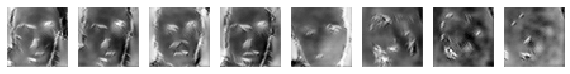

Epoch: 1380
Discriminator loss: [0.2876560688018799, 0.5]
Generator loss: [0.08027378469705582, 1.0]


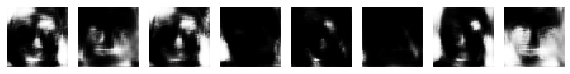

Epoch: 1400
Discriminator loss: [0.25015413761138916, 0.5]
Generator loss: [1.8370211124420166, 0.109375]


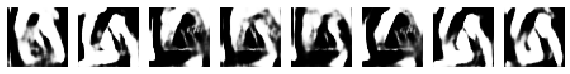

Epoch: 1420
Discriminator loss: [0.2224239706993103, 0.5]
Generator loss: [3.8033061027526855, 0.03125]


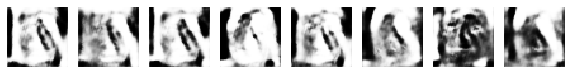

Epoch: 1440
Discriminator loss: [0.30579543113708496, 0.4921875]
Generator loss: [1.8320703506469727, 0.0625]


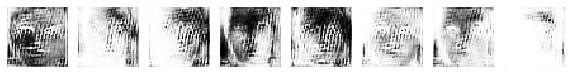

Epoch: 1460
Discriminator loss: [0.30384430289268494, 0.5]
Generator loss: [9.433735847473145, 0.0]


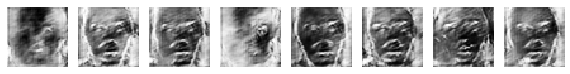

Epoch: 1480
Discriminator loss: [0.5398796796798706, 0.4375]
Generator loss: [3.1866042613983154, 0.0625]


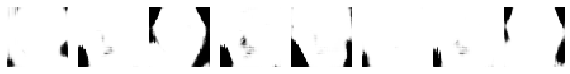

Epoch: 1500
Discriminator loss: [0.22351694107055664, 0.5]
Generator loss: [3.1186184883117676, 0.0625]


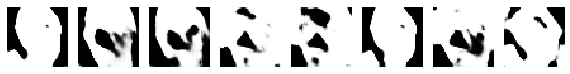

Epoch: 1520
Discriminator loss: [0.23140472173690796, 0.5]
Generator loss: [4.056677341461182, 0.015625]


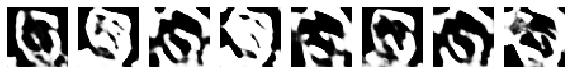

Epoch: 1540
Discriminator loss: [0.2261570394039154, 0.5]
Generator loss: [6.451798915863037, 0.0]


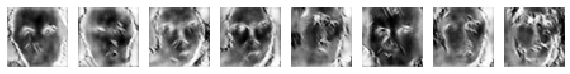

Epoch: 1560
Discriminator loss: [0.5851538777351379, 0.4296875]
Generator loss: [0.27632850408554077, 1.0]


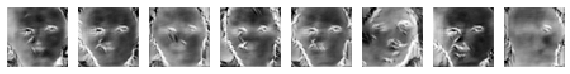

Epoch: 1580
Discriminator loss: [0.3352978527545929, 0.5]
Generator loss: [0.1979738026857376, 0.96875]


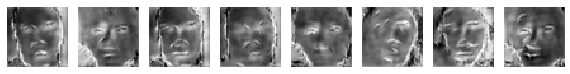

Epoch: 1600
Discriminator loss: [0.2820024788379669, 0.4921875]
Generator loss: [0.13210327923297882, 0.984375]


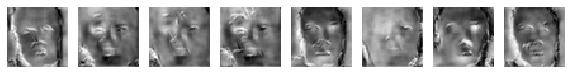

Epoch: 1620
Discriminator loss: [0.3416796326637268, 0.5]
Generator loss: [0.11541401594877243, 1.0]


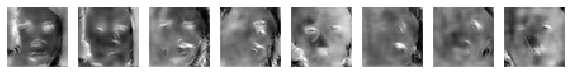

Epoch: 1640
Discriminator loss: [0.24632956087589264, 0.5]
Generator loss: [0.16588033735752106, 0.984375]


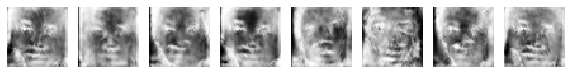

Epoch: 1660
Discriminator loss: [0.4206903874874115, 0.4921875]
Generator loss: [0.0580773688852787, 1.0]


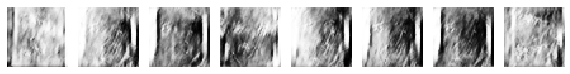

Epoch: 1680
Discriminator loss: [0.4917234480381012, 0.46875]
Generator loss: [0.812579870223999, 0.5625]


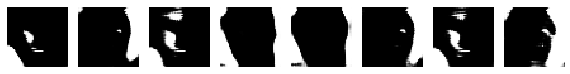

Epoch: 1700
Discriminator loss: [0.24270354211330414, 0.5]
Generator loss: [1.0361357927322388, 0.546875]


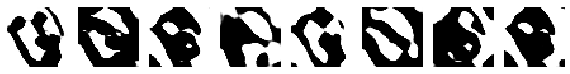

Epoch: 1720
Discriminator loss: [0.21639716625213623, 0.5]
Generator loss: [6.102034091949463, 0.0]


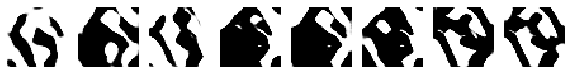

Epoch: 1740
Discriminator loss: [0.21775642037391663, 0.5]
Generator loss: [7.875601291656494, 0.0]


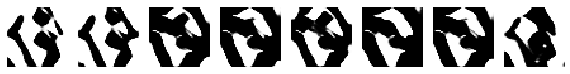

Epoch: 1760
Discriminator loss: [0.21328073740005493, 0.5]
Generator loss: [6.421281814575195, 0.0]


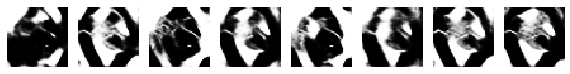

Epoch: 1780
Discriminator loss: [0.3171422481536865, 0.5]
Generator loss: [5.556501865386963, 0.0]


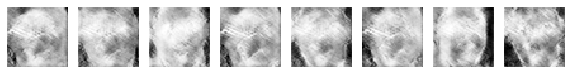

Epoch: 1800
Discriminator loss: [0.2525086998939514, 0.5]
Generator loss: [0.08079539984464645, 1.0]


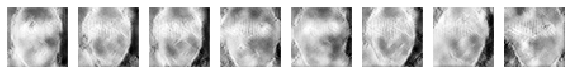

Epoch: 1820
Discriminator loss: [0.2505757212638855, 0.5]
Generator loss: [0.14712798595428467, 0.984375]


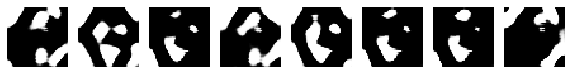

Epoch: 1840
Discriminator loss: [0.22865861654281616, 0.5]
Generator loss: [1.0060255527496338, 0.484375]


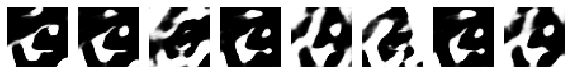

Epoch: 1860
Discriminator loss: [0.2086549550294876, 0.5]
Generator loss: [3.623736619949341, 0.0]


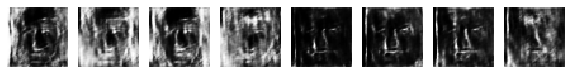

Epoch: 1880
Discriminator loss: [0.27566686272621155, 0.5]
Generator loss: [2.0500009059906006, 0.15625]


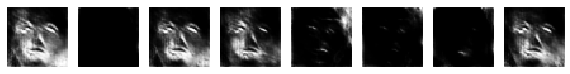

Epoch: 1900
Discriminator loss: [0.2788543999195099, 0.4921875]
Generator loss: [3.7461085319519043, 0.0]


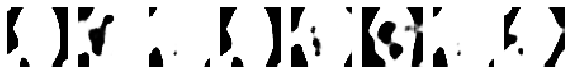

Epoch: 1920
Discriminator loss: [0.2525866627693176, 0.5]
Generator loss: [3.5211360454559326, 0.03125]


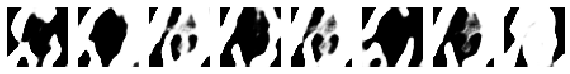

Epoch: 1940
Discriminator loss: [0.20997698605060577, 0.5]
Generator loss: [7.707554340362549, 0.0]


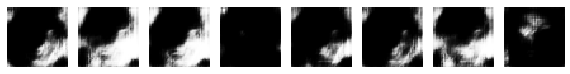

Epoch: 1960
Discriminator loss: [0.2560811936855316, 0.484375]
Generator loss: [5.348209381103516, 0.015625]


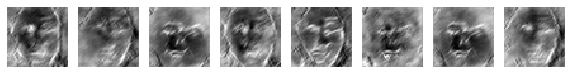

Epoch: 1980
Discriminator loss: [0.37860625982284546, 0.5]
Generator loss: [0.06957105547189713, 1.0]


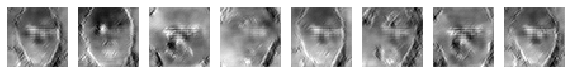

Epoch: 2000
Discriminator loss: [0.22513343393802643, 0.5]
Generator loss: [0.0742022693157196, 1.0]


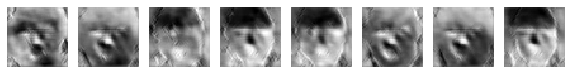

Epoch: 2020
Discriminator loss: [0.2540709674358368, 0.5]
Generator loss: [0.13479433953762054, 1.0]


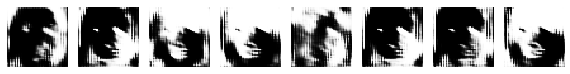

Epoch: 2040
Discriminator loss: [0.21496780216693878, 0.5]
Generator loss: [0.9044689536094666, 0.578125]


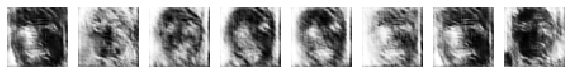

Epoch: 2060
Discriminator loss: [1.0338629484176636, 0.4296875]
Generator loss: [1.8484278917312622, 0.03125]


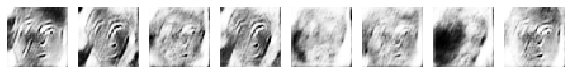

Epoch: 2080
Discriminator loss: [0.27843084931373596, 0.5]
Generator loss: [2.432142972946167, 0.046875]


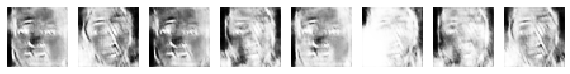

Epoch: 2100
Discriminator loss: [0.28450679779052734, 0.5]
Generator loss: [0.9895476698875427, 0.46875]


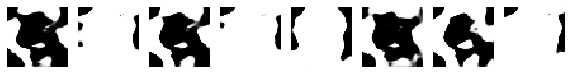

Epoch: 2120
Discriminator loss: [0.2229236662387848, 0.5]
Generator loss: [6.883584976196289, 0.0]


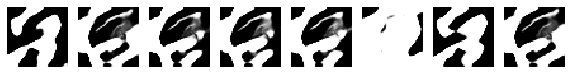

Epoch: 2140
Discriminator loss: [0.21689002215862274, 0.5]
Generator loss: [9.007369995117188, 0.0]


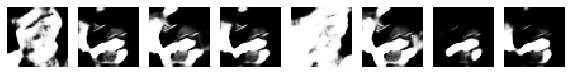

Epoch: 2160
Discriminator loss: [0.20956657826900482, 0.5]
Generator loss: [8.33614444732666, 0.0]


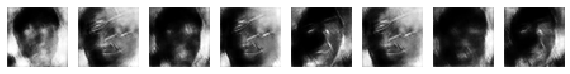

Epoch: 2180
Discriminator loss: [0.24737344682216644, 0.5]
Generator loss: [0.2844127416610718, 0.921875]


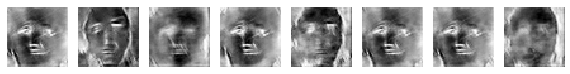

Epoch: 2200
Discriminator loss: [0.407144695520401, 0.484375]
Generator loss: [0.192271426320076, 0.984375]


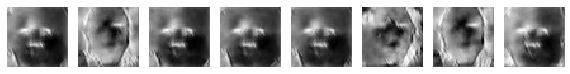

Epoch: 2220
Discriminator loss: [0.23561975359916687, 0.5]
Generator loss: [0.1843315213918686, 1.0]


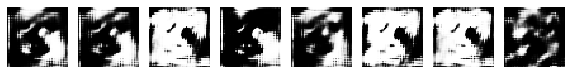

Epoch: 2240
Discriminator loss: [0.21633802354335785, 0.5]
Generator loss: [1.3686668872833252, 0.25]


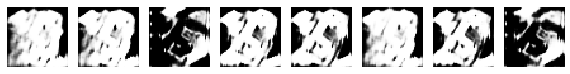

Epoch: 2260
Discriminator loss: [0.276751846075058, 0.5]
Generator loss: [3.431211233139038, 0.0]


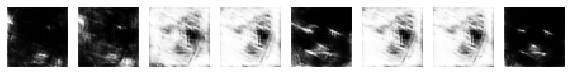

Epoch: 2280
Discriminator loss: [0.27448606491088867, 0.5]
Generator loss: [3.3125929832458496, 0.0]


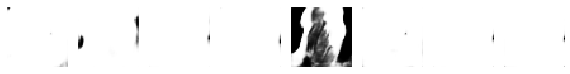

Epoch: 2300
Discriminator loss: [0.2161531150341034, 0.5]
Generator loss: [4.1395063400268555, 0.0]


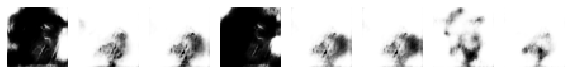

Epoch: 2320
Discriminator loss: [0.2227001041173935, 0.5]
Generator loss: [5.940444469451904, 0.0]


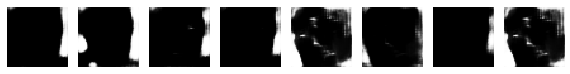

Epoch: 2340
Discriminator loss: [0.2915772497653961, 0.5]
Generator loss: [3.4080379009246826, 0.0]


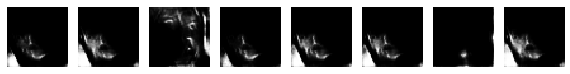

Epoch: 2360
Discriminator loss: [0.23606742918491364, 0.5]
Generator loss: [3.552372932434082, 0.0]


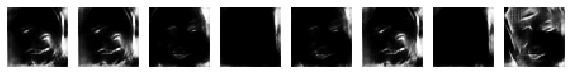

Epoch: 2380
Discriminator loss: [0.3404467701911926, 0.5]
Generator loss: [3.6474833488464355, 0.015625]


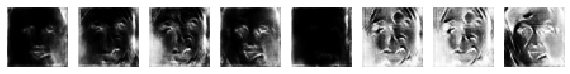

Epoch: 2400
Discriminator loss: [0.22546017169952393, 0.5]
Generator loss: [4.30767297744751, 0.0]


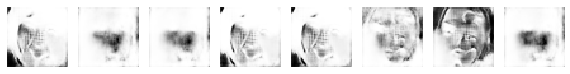

Epoch: 2420
Discriminator loss: [0.21611854434013367, 0.5]
Generator loss: [2.5988242626190186, 0.046875]


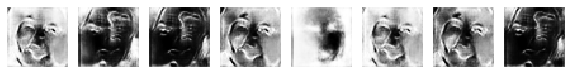

Epoch: 2440
Discriminator loss: [0.3408541679382324, 0.5]
Generator loss: [3.286375045776367, 0.0]


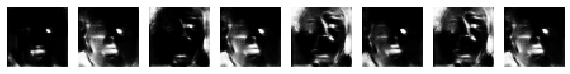

Epoch: 2460
Discriminator loss: [0.2836582660675049, 0.5]
Generator loss: [1.399572730064392, 0.140625]


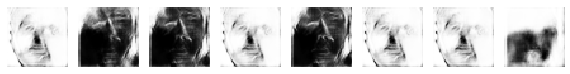

Epoch: 2480
Discriminator loss: [0.268889844417572, 0.46875]
Generator loss: [3.3330650329589844, 0.0625]


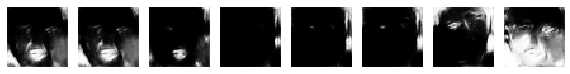

Epoch: 2500
Discriminator loss: [0.29178380966186523, 0.4921875]
Generator loss: [2.1740965843200684, 0.09375]


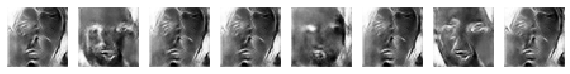

Epoch: 2520
Discriminator loss: [0.5865717530250549, 0.453125]
Generator loss: [0.4288480877876282, 0.859375]


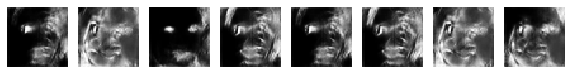

Epoch: 2540
Discriminator loss: [0.5406048893928528, 0.3203125]
Generator loss: [1.2828935384750366, 0.5]


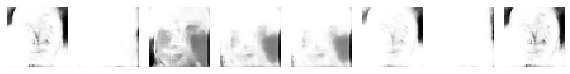

Epoch: 2560
Discriminator loss: [0.2281356304883957, 0.5]
Generator loss: [1.9236925840377808, 0.203125]


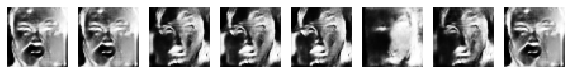

Epoch: 2580
Discriminator loss: [0.27361834049224854, 0.5]
Generator loss: [3.5653786659240723, 0.0]


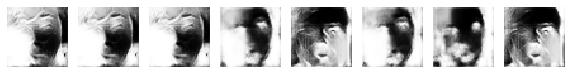

Epoch: 2600
Discriminator loss: [0.4030550718307495, 0.453125]
Generator loss: [3.242851495742798, 0.015625]


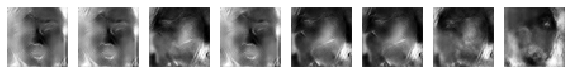

Epoch: 2620
Discriminator loss: [0.26270872354507446, 0.5]
Generator loss: [0.18084433674812317, 0.984375]


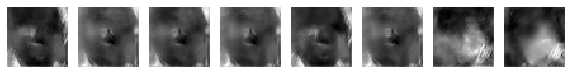

Epoch: 2640
Discriminator loss: [0.21302850544452667, 0.5]
Generator loss: [0.09520319104194641, 1.0]


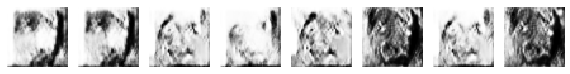

Epoch: 2660
Discriminator loss: [0.26699578762054443, 0.484375]
Generator loss: [3.2044198513031006, 0.0]


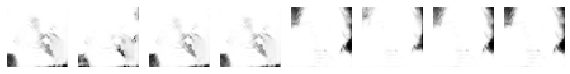

Epoch: 2680
Discriminator loss: [0.20796369016170502, 0.5]
Generator loss: [4.521701812744141, 0.0]


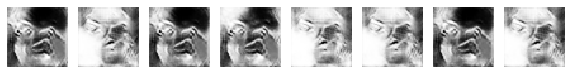

Epoch: 2700
Discriminator loss: [0.31014880537986755, 0.5]
Generator loss: [2.2501654624938965, 0.125]


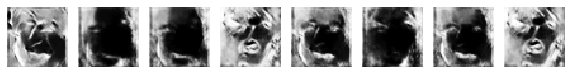

Epoch: 2720
Discriminator loss: [0.29148006439208984, 0.5]
Generator loss: [3.012659788131714, 0.015625]


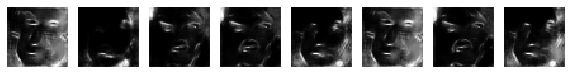

Epoch: 2740
Discriminator loss: [0.21801318228244781, 0.5]
Generator loss: [3.99642014503479, 0.0]


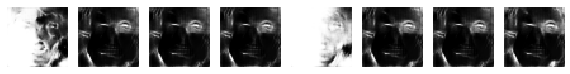

Epoch: 2760
Discriminator loss: [0.23019662499427795, 0.5]
Generator loss: [4.658802509307861, 0.0]


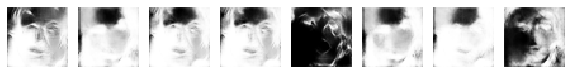

Epoch: 2780
Discriminator loss: [0.2704157829284668, 0.484375]
Generator loss: [5.207472801208496, 0.0]


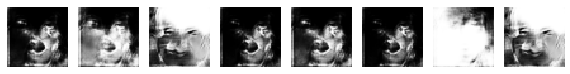

Epoch: 2800
Discriminator loss: [0.2696220278739929, 0.5]
Generator loss: [5.38019323348999, 0.0]


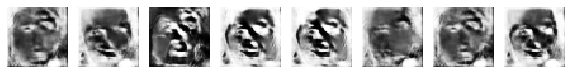

Epoch: 2820
Discriminator loss: [0.37631839513778687, 0.46875]
Generator loss: [0.6221174001693726, 0.671875]


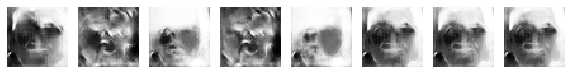

Epoch: 2840
Discriminator loss: [0.4535295069217682, 0.421875]
Generator loss: [0.6724423170089722, 0.578125]


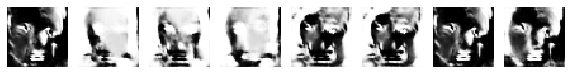

Epoch: 2860
Discriminator loss: [0.2257692515850067, 0.5]
Generator loss: [5.209183216094971, 0.0]


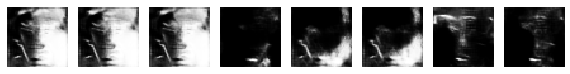

Epoch: 2880
Discriminator loss: [0.22999651730060577, 0.5]
Generator loss: [7.25495719909668, 0.0]


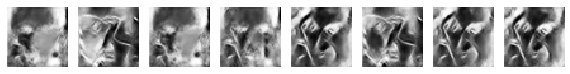

Epoch: 2900
Discriminator loss: [0.40607750415802, 0.4921875]
Generator loss: [0.13698039948940277, 1.0]


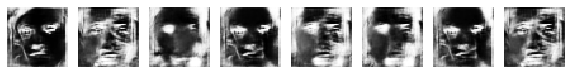

Epoch: 2920
Discriminator loss: [0.27630484104156494, 0.4921875]
Generator loss: [0.4287751019001007, 0.859375]


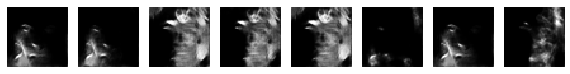

Epoch: 2940
Discriminator loss: [0.22780807316303253, 0.5]
Generator loss: [4.360981464385986, 0.015625]


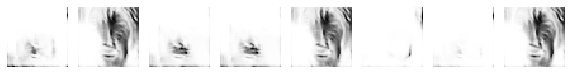

Epoch: 2960
Discriminator loss: [0.23445074260234833, 0.5]
Generator loss: [2.168671131134033, 0.015625]


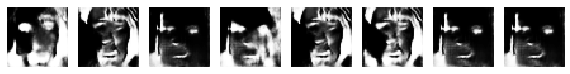

Epoch: 2980
Discriminator loss: [0.25736597180366516, 0.5]
Generator loss: [3.4118545055389404, 0.0]


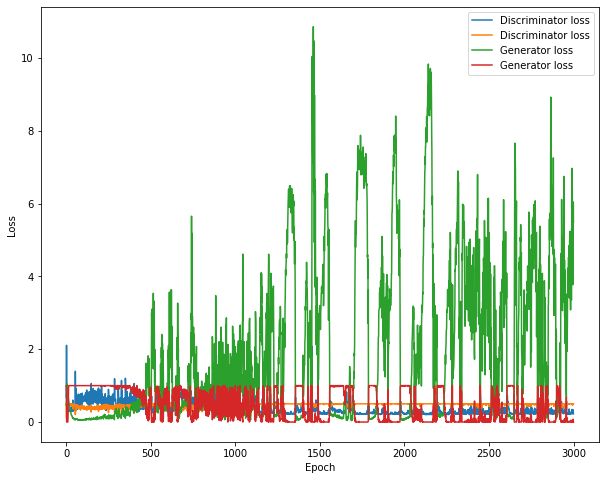

In [60]:
def main():
    # set hyper parameters    
    batch_size = 64
    epochs = 3000
    learning_rate = 0.001
    z_input_dim = 100
    n_iter_D = 1
    n_iter_G = 5

    # run model
    model = Model(batch_size, epochs, learning_rate, z_input_dim, n_iter_D, n_iter_G)
    model.fit()


if __name__ == '__main__':
    main()